In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%reset -f

In [2]:
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from yellowbrick.regressor import residuals_plot

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

from scipy import stats
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import time

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn import ensemble

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import unique_labels
import tensorflow as tf

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Near-Fault Ground Motion

## Velocity Pulses

### Load data

In [3]:
# Load data
data_vp=pd.read_csv('Result_Velocity_Pulse_Bridge_Property.csv',header=None)
data_vp.iloc[:,1]=1/data_vp.iloc[:,1]
data_vp.columns = ['Gamma','fp','A','PGA','Weight','Height','K1','Q','K2','T','Q/W','Drift']
data_vp.head()

,Gamma,fp,A,PGA,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,2,0.729927,1.018,4.23000,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.107840
1,2,0.446429,0.306,0.77762,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.039144
2,2,0.476190,0.433,1.17380,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.048381
3,2,0.333333,0.860,1.63190,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.091070
4,2,0.196464,0.274,0.30644,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.033666


### Data Inspection

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

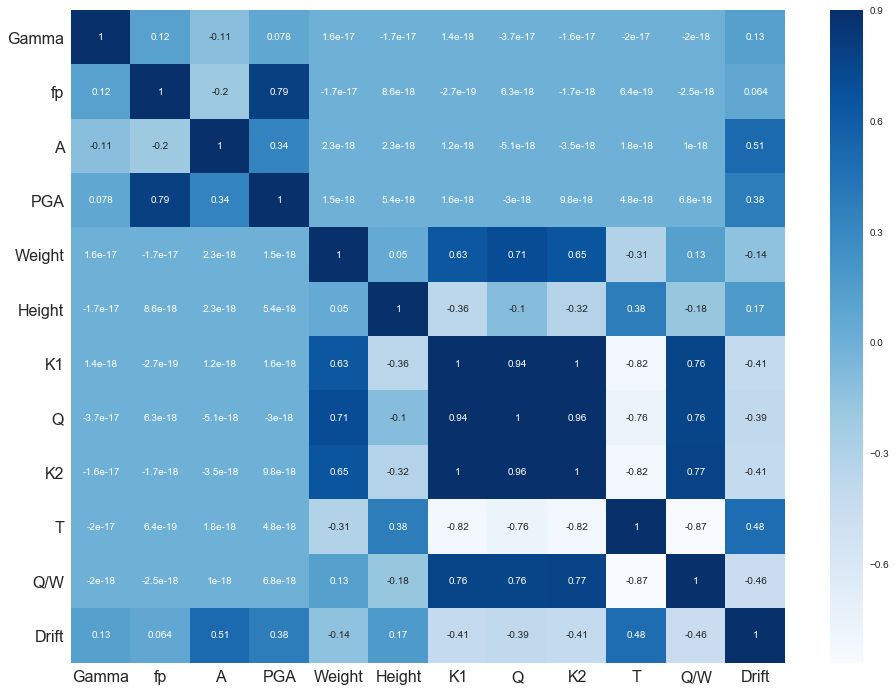

In [4]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
plt.xticks(rotation = 0,fontsize=16)
plt.yticks(fontsize=16)
#sns.heatmap(data_vp.corr(), vmax=0.9, cmap="YlGnBu" or "coolwarm", square=True, annot=True)
sns.heatmap(data_vp.corr(), vmax=0.9, cmap="Blues",  annot=True)

### Feature Selection

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Gamma$ (F-test=0.05, MI=0.11)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$fp$ (F-test=0.01, MI=0.99)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$A$ (F-test=1.00, MI=1.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Weight$ (F-test=0.06, MI=0.13)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Height$ (F-test=0.08, MI=0.22)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K1$ (F-test=0.59, MI=0.33)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K2$ (F-test=0.59, MI=0.31)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$T$ (F-test=0.85, MI=0.39)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Q/W$ (F-test=0.75, MI=0.37)')

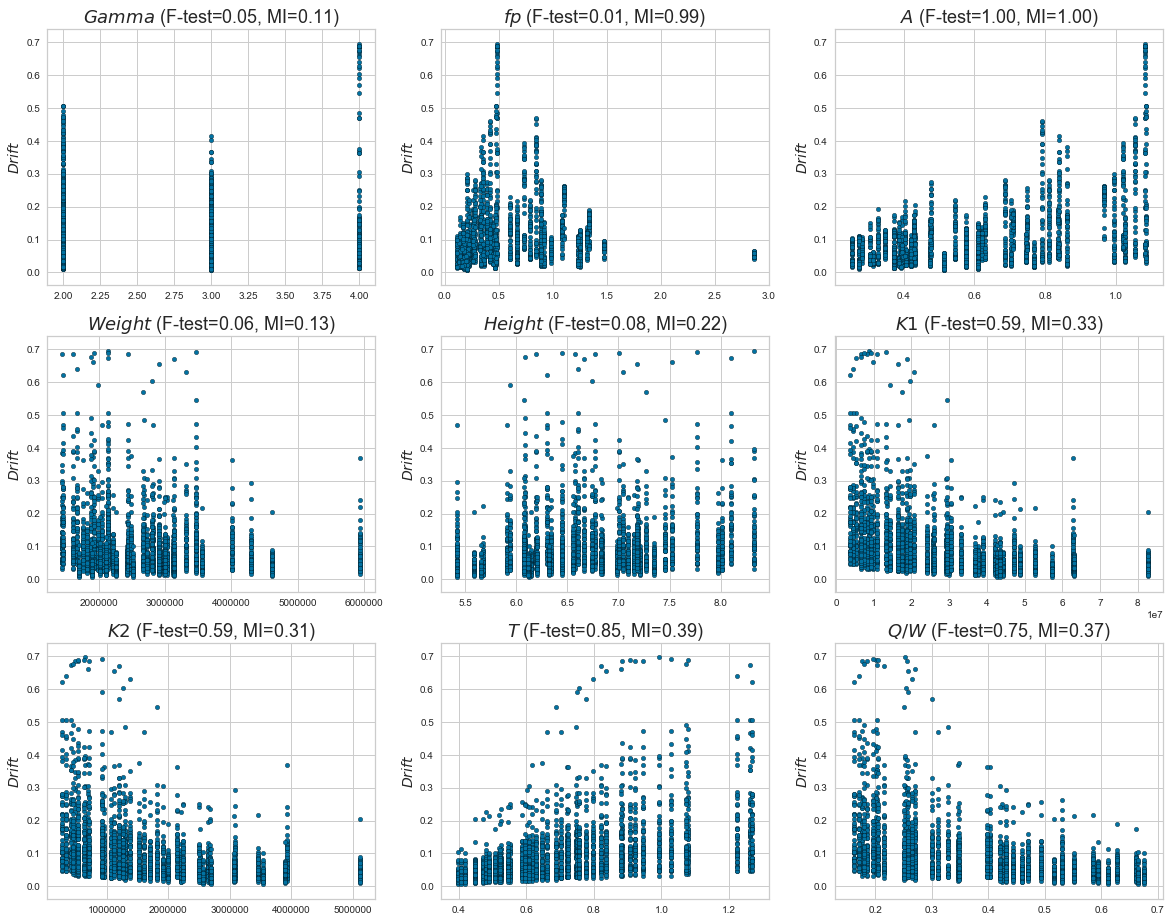

In [105]:
selected_feature_index = [0,1,2,4,5,6,8,9,10]
f_test, _ = f_regression(data_vp.iloc[:,selected_feature_index], data_vp.iloc[:,11])
f_test = f_test / np.max(f_test)
mi = mutual_info_regression(data_vp.iloc[:,selected_feature_index], data_vp.iloc[:,11])
mi = mi/np.max(mi)
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for i,axes in zip(range(10),ax.flatten()):
    axes.scatter(data_vp.iloc[:,selected_feature_index[i]], data_vp.iloc[:,11], edgecolor='black', s=20)
    #axes.set_xlabel("${}$".format(data_vp.columns[selected_feature_index[i]]), fontsize=14)
    axes.set_ylabel("$Drift$", fontsize=14)
    axes.set_title("${}$ (F-test={:.2f}, MI={:.2f})".format(data_vp.columns[selected_feature_index[i]],f_test[i], mi[i]),
              fontsize=18)



### Regression Analysis

In [106]:
# train
#X=np.array(Total_data.drop(['Weight','Height','K1','Q','K2','Drift'],axis=1))
X_vp=np.array(data_vp.drop(['PGA','Weight','K1','Q','K2','Drift'],axis=1))
y_vp=data_vp.values[:,11]

#Keep height for further drift ratio
X_train_vp, X_val_vp,y_train_vp,y_val_vp = train_test_split(X_vp,y_vp, test_size=0.2,shuffle=True)
Height_train_vp=X_train_vp[:,3]
Height_val_vp=X_val_vp[:,3]
X_train_vp=np.delete(X_train_vp, 3,axis=1)
X_val_vp=np.delete(X_val_vp, 3,axis=1)    

In [4]:
def score(model_name,y_val,y_val_pred):
    print("The calculated RMSE for"+model_name+" is:%0.8f" % (sqrt(mean_squared_error(y_val, y_val_pred))))
    ARD = np.absolute(y_val_pred-y_val)/(y_val)
    MARD=np.median(np.absolute(y_val_pred-y_val)/(y_val))
    print("The median absolute relative deviation is %.4f "% (MARD))
    r2 = r2_score(y_val, y_val_pred)
    print("The R squared  is %.4f "% (r2))
    return ARD

In [5]:
def plot_result(model,model_name,title,X_train,y_train,X_val,y_val,y_val_pred):
    plt.figure(figsize=(9,9))
    plt.subplot(211)
    plt.scatter(y_val,y_val_pred,s=10, c='k')
    plt.title(model_name,fontsize=18)
    plt.xlabel("True Value")
    plt.ylabel("Prediction")
    #plt.grid(True, linestyle = "-", color = "r", linewidth = "1")
    #plt.grid(False)
    #plt.show()
    #sns.set(style="whitegrid")
    # Plot the residuals after fitting a linear model
    #sns.residplot(y_lm_val_vp, y_val_vp, lowess=False, color="g")
    #lm_vp = LinearRegression()
    plt.subplot(212)
    visualizer = ResidualsPlot(model,hist=False)
    visualizer.fit(X_train,y_train)  
    visualizer.score(X_val, y_val)  # Evaluate the model on the test data 
    #g = visualizer.poof()
    visualizer.finalize()
    visualizer.ax.set_title("")
    plt.savefig(title+ ".eps")
    plt.savefig(title+ ".png")

#### Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[ 0.02462629  0.03088349  0.2229137   0.14719202 -0.09866286]
The calculated RMSE forLinear Regression is:0.06968944
The median absolute relative deviation is 0.4689 
The R squared  is 0.5098 


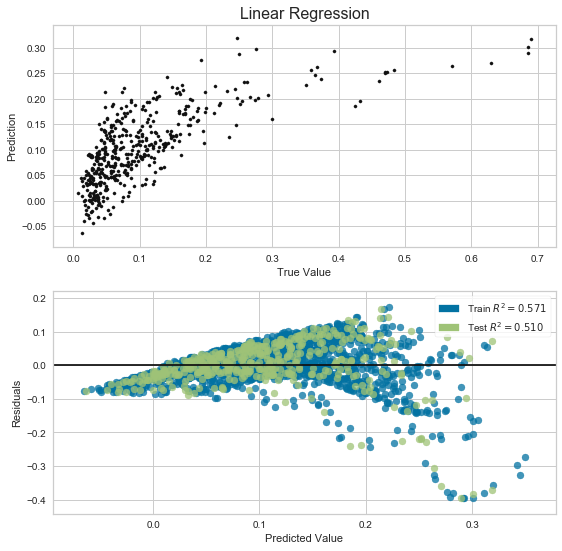

In [66]:
lm_vp = LinearRegression()
lm_vp.fit(X_train_vp,y_train_vp)
#y_train_pred=lm.predict(X_train_scale)
y_lm_val_vp= lm_vp.predict(X_val_vp)
print(lm_vp.coef_)
#print("The calculated RMSE for Linear Regression is:%0.8f" % (sqrt(mean_squared_error(y_val_vp, y_lm_val_vp))))
#MARD_lm_vp=np.median(np.absolute(y_lm_val_vp-y_val_vp)/(y_val_vp))
#print("The median absolute relative deviation is %.4f "% (MARD_lm_vp))
#r2_lm_vp = r2_score(y_val_vp, y_lm_val_vp)
#print("The R squared  is %.4f "% (r2_lm_vp))
model_name='Linear Regression'
score(model_name,y_val_vp,y_lm_val_vp)
title=model_name+' Velocity Pulse'
plot_result(lm_vp,model_name,title,X_train_vp,y_train_vp,X_val_vp,y_val_vp,y_lm_val_vp)

#### Polynomial Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The calculated RMSE forPolynomial Regression is:0.05052729
The median absolute relative deviation is 0.3322 
The R squared  is 0.7423 


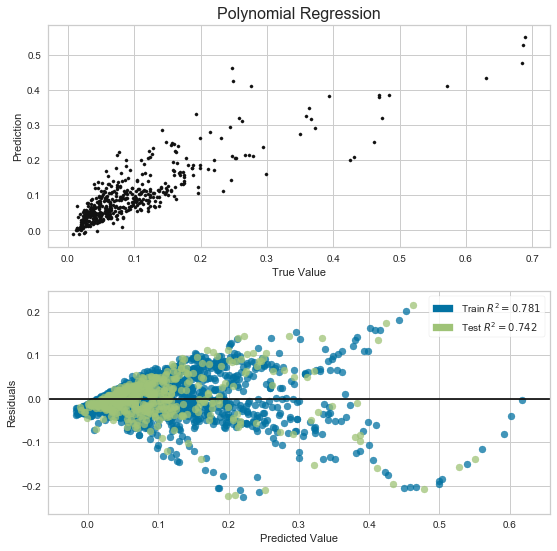

In [67]:
d=2
polynomial_features= PolynomialFeatures(degree=d)
x_poly_train_vp = polynomial_features.fit_transform(X_train_vp)
x_poly_val_vp = polynomial_features.fit_transform(X_val_vp)
poly_vp = LinearRegression()
poly_vp.fit(x_poly_train_vp,y_train_vp)
y_poly_val_vp = poly_vp.predict(x_poly_val_vp)

model_name='Polynomial Regression'
score(model_name,y_val_vp,y_poly_val_vp)
title=model_name+' Velocity Pulse'
plot_result(poly_vp,model_name,title,x_poly_train_vp,y_train_vp,x_poly_val_vp,y_val_vp,y_poly_val_vp)

#### Kernel Ridge Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best estimator found by grid search:
{'alpha': 0.00031622776601683794, 'gamma': 10.0}
The calculated RMSE forKernel Ridge Regression is:0.06968944
The median absolute relative deviation is 0.4689 
The R squared  is 0.5098 


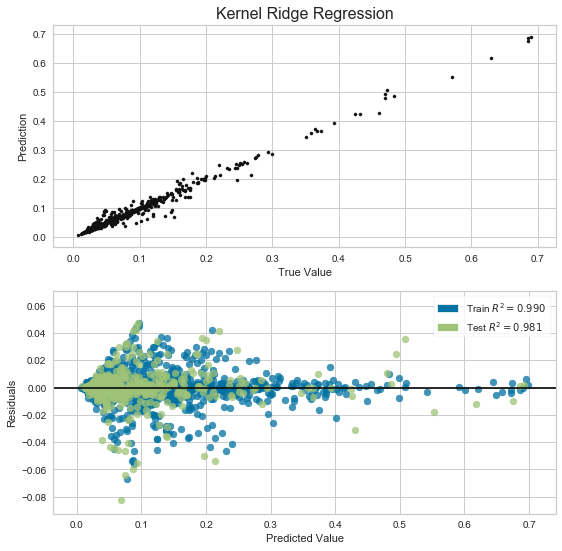

In [68]:
param_grid_kr ={"alpha": np.logspace(-5,-2,5),"gamma": np.logspace(-2,2,5)}
kr_vp = GridSearchCV(estimator=KernelRidge(kernel='rbf'),param_grid=param_grid_kr, cv=5)
#kr=KernelRidge(alpha=0.0001,gamma=10.0)
kr_vp.fit(X_train_vp, y_train_vp)
y_kr_val_vp = kr_vp.predict(X_val_vp)
print("Best estimator found by grid search:")
print(kr_vp.best_params_)

model_name='Kernel Ridge Regression'
score(model_name,y_val_vp,y_lm_val_vp)
title=model_name+' Velocity Pulse'
plot_result(kr_vp,model_name,title,X_train_vp,y_train_vp,X_val_vp,y_val_vp,y_kr_val_vp)

#### Support Vector Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'epsilon': [0.001, 0.01, 0.1],
                         'gamma': array([  1.,  10., 100.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Support vector ratio: 0.851
Best estimator found by grid search:
{'C': 10.0, 'epsilon': 0.001, 'gamma': 10.0}
The calculated RMSE forSupport Vector Regression is:0.01544086
The median absolute relative deviation is 0.0517 
The R squared  is 0.9759 


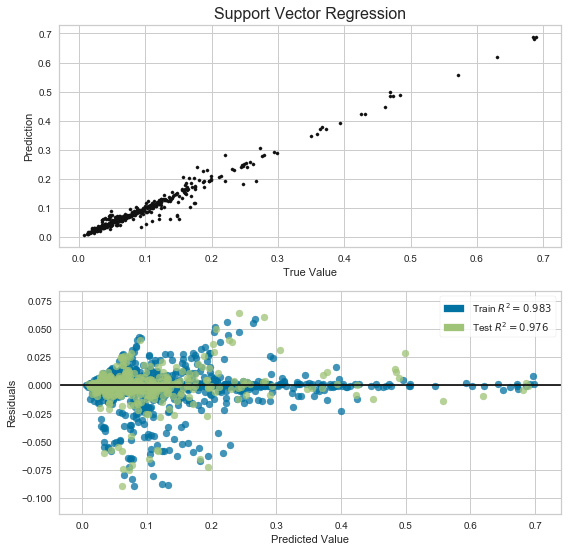

In [69]:
param_grid_svr={"C": np.logspace(0, 3, 4),"gamma": np.logspace(0, 2, 3), "epsilon": [0.001, 0.01, 0.1]}
svr_vp = GridSearchCV(SVR(kernel='rbf',cache_size=1000),param_grid_svr ,cv=5)

svr_vp.fit(X_train_vp, y_train_vp)

sv_ratio = svr_vp.best_estimator_.support_.shape[0] / X_train_vp.shape[0]
print("Support vector ratio: %.3f" % sv_ratio)

y_svr_val_vp = svr_vp.predict(X_val_vp)
print("Best estimator found by grid search:")
print(svr_vp.best_params_)

model_name='Support Vector Regression'
score(model_name,y_val_vp,y_svr_val_vp)
title=model_name+' Velocity Pulse'
plot_result(svr_vp,model_name,title,X_train_vp,y_train_vp,X_val_vp,y_val_vp,y_svr_val_vp)

#### Gradient Boosting Machine

Starting training...
[1]	valid_0's l2: 0.00928252	valid_0's l1: 0.0629171
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.00882627	valid_0's l1: 0.0609197
[3]	valid_0's l2: 0.00827723	valid_0's l1: 0.0588164
[4]	valid_0's l2: 0.00778804	valid_0's l1: 0.056874
[5]	valid_0's l2: 0.00734172	valid_0's l1: 0.055142
[6]	valid_0's l2: 0.00683902	valid_0's l1: 0.0530889
[7]	valid_0's l2: 0.0065091	valid_0's l1: 0.0515139
[8]	valid_0's l2: 0.00616066	valid_0's l1: 0.0501156
[9]	valid_0's l2: 0.00576115	valid_0's l1: 0.0483369
[10]	valid_0's l2: 0.00538325	valid_0's l1: 0.046653
[11]	valid_0's l2: 0.00511503	valid_0's l1: 0.0454884
[12]	valid_0's l2: 0.00482107	valid_0's l1: 0.0440006
[13]	valid_0's l2: 0.00460009	valid_0's l1: 0.0429476
[14]	valid_0's l2: 0.00440121	valid_0's l1: 0.041977
[15]	valid_0's l2: 0.00424435	valid_0's l1: 0.0408519
[16]	valid_0's l2: 0.00408375	valid_0's l1: 0.0400611
[17]	valid_0's l2: 0.00386707	valid_0's l1: 0.0387811
[18]	valid_0's

YellowbrickTypeError: This estimator is not a regressor; try a classifier or clustering score visualizer instead!

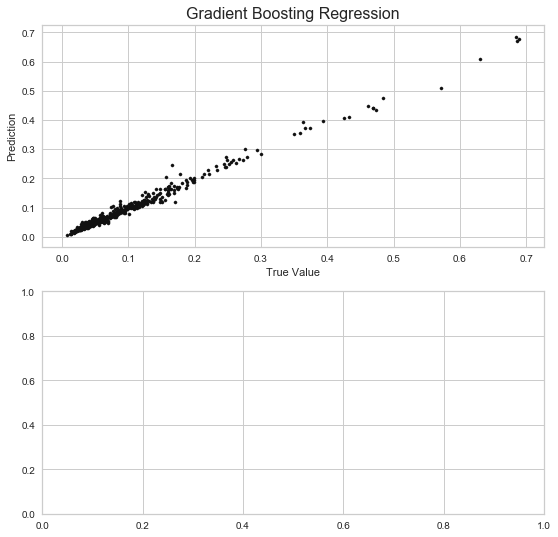

In [70]:
# specify your configurations as a dict
# use rmsle to give more penlty for under-predicted value
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'max_depth': 6,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

lgb_train_vp = lgb.Dataset(X_train_vp, y_train_vp)
lgb_val_vp = lgb.Dataset(X_val_vp, y_val_vp, reference=lgb_train_vp)

print('Starting training...')

lgb_vp = lgb.train(params,
                lgb_train_vp,
                num_boost_round=10000,
                valid_sets=lgb_val_vp,
                early_stopping_rounds=20)

## Check pretrained model performance
y_lgb_val_vp= lgb_vp.predict(X_val_vp, num_iteration=lgb_vp.best_iteration)

model_name='Gradient Boosting Regression'
score(model_name,y_val_vp,y_lgb_val_vp)
title=model_name+' Velocity Pulse'
plot_result(lgb_vp,model_name,title,X_train_vp,y_train_vp,X_val_vp,y_val_vp,y_lgb_val_vp)

#### Random Forest Regression

In [71]:
regressor = RandomForestRegressor(random_state=9,oob_score=True)
parameters = [{'max_features' : ['auto','sqrt','log2'],'n_estimators' : [10,20,40,60,80,100],'max_depth':[5,10,15,20,25,30]}]
rf_vp = GridSearchCV(estimator = regressor, param_grid = parameters)
rf_vp.fit(X_train_vp, y_train_vp)
best_parameters = rf_vp.best_params_
# Best paramete set
print('Best parameters found:\n', best_parameters)
y_rf_val_vp= rf_vp.predict(X_val_vp)

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=9,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

Best parameters found:
 {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}


The calculated RMSE forRandom Forest Regression is:0.01246101
The median absolute relative deviation is 0.0541 
The R squared  is 0.9843 


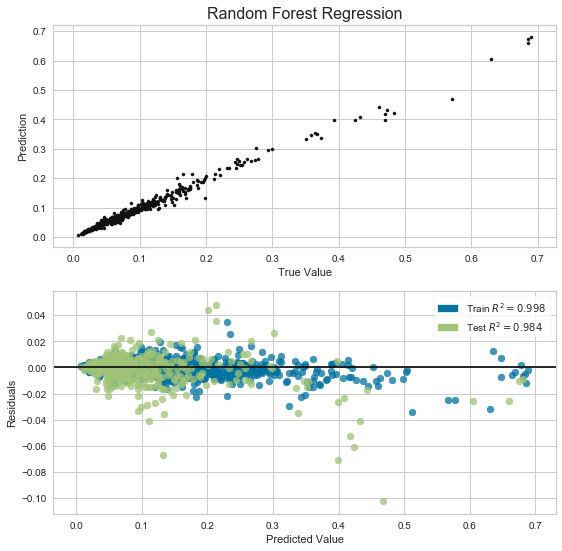

In [72]:
model_name='Random Forest Regression'
score(model_name,y_val_vp,y_rf_val_vp)
title=model_name+' Velocity Pulse'
plot_result(rf_vp,model_name,title,X_train_vp,y_train_vp,X_val_vp,y_val_vp,y_rf_val_vp)

## Acceleration Pulses

### Load Data

In [6]:
# Load data
data_ap=pd.read_csv('Result_Acceleration_Pulse_Bridge_Property.csv',header=None)
data_ap.iloc[:,1]=1/data_ap.iloc[:,1]
data_ap.columns = ['Gamma','fp','A','PGA','Weight','Height','K1','Q','K2','T','Q/W','Drift']
data_ap.head()

,Gamma,fp,A,PGA,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,2,1.923077,0.207029,2.5008,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.042427
1,3,2.500000,0.111165,1.7456,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.017390
2,4,3.571429,0.101860,2.2850,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.016730
3,5,3.846154,0.128683,3.1088,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.016387
4,3,5.555556,0.053397,1.8633,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.010020


### Data Inspection

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

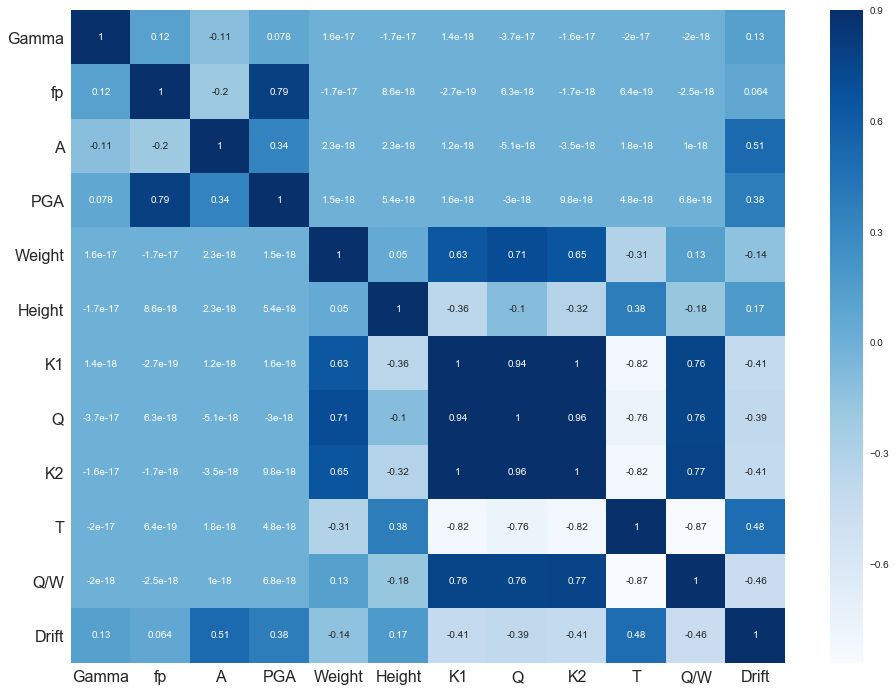

In [111]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
plt.xticks(rotation = 0,fontsize=16)
plt.yticks(fontsize=16)
#sns.heatmap(data_vp.corr(), vmax=0.9, cmap="YlGnBu" or "coolwarm", square=True, annot=True)
sns.heatmap(data_vp.corr(), vmax=0.9, cmap="Blues",  annot=True)

### Feature Selection

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Gamma$ (F-test=0.06, MI=0.32)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$fp$ (F-test=0.22, MI=1.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$A$ (F-test=1.00, MI=0.99)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Weight$ (F-test=0.00, MI=0.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Height$ (F-test=0.01, MI=0.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K1$ (F-test=0.04, MI=0.01)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K2$ (F-test=0.04, MI=0.01)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$T$ (F-test=0.06, MI=0.08)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Q/W$ (F-test=0.06, MI=0.02)')

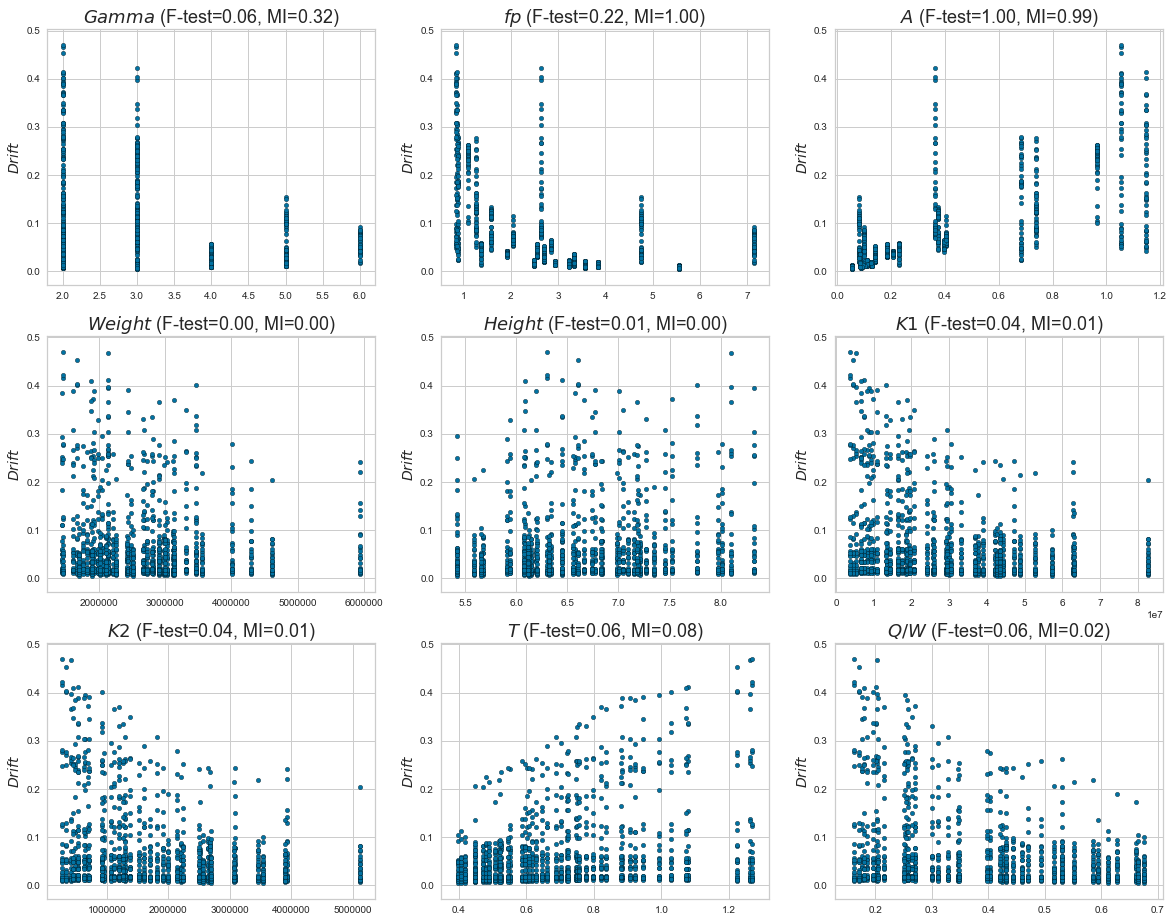

In [75]:
selected_feature_index = [0,1,2,4,5,6,8,9,10]
f_test, _ = f_regression(data_ap.iloc[:,selected_feature_index], data_ap.iloc[:,11])
f_test = f_test / np.max(f_test)
mi = mutual_info_regression(data_ap.iloc[:,selected_feature_index], data_ap.iloc[:,11])
mi = mi/np.max(mi)
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for i,axes in zip(range(10),ax.flatten()):
    axes.scatter(data_ap.iloc[:,selected_feature_index[i]], data_ap.iloc[:,11], edgecolor='black', s=20)
    #axes.set_xlabel("${}$".format(data_vp.columns[selected_feature_index[i]]), fontsize=14)
    axes.set_ylabel("$Drift$", fontsize=14)
    axes.set_title("${}$ (F-test={:.2f}, MI={:.2f})".format(data_vp.columns[selected_feature_index[i]],f_test[i], mi[i]),
              fontsize=18)

### Regression Analysis

In [76]:
# train
#X=np.array(Total_data.drop(['Weight','Height','K1','Q','K2','Drift'],axis=1))
X_ap=np.array(data_ap.drop(['PGA','Weight','K1','Q','K2','Drift'],axis=1))
y_ap=data_ap.values[:,11]

#Keep height for further drift ratio
X_train_ap, X_val_ap,y_train_ap,y_val_ap = train_test_split(X_ap,y_ap, test_size=0.2,shuffle=True)
Height_train_ap=X_train_ap[:,3]
Height_val_ap=X_val_ap[:,3]
X_train_ap=np.delete(X_train_ap, 3,axis=1)
X_val_ap=np.delete(X_val_ap, 3,axis=1)  

#### Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[ 0.00708542  0.00267309  0.22806843  0.0803955  -0.04825848]
The calculated RMSE forLinear Regression is:0.04901114
The median absolute relative deviation is 0.5054 
The R squared  is 0.6854 


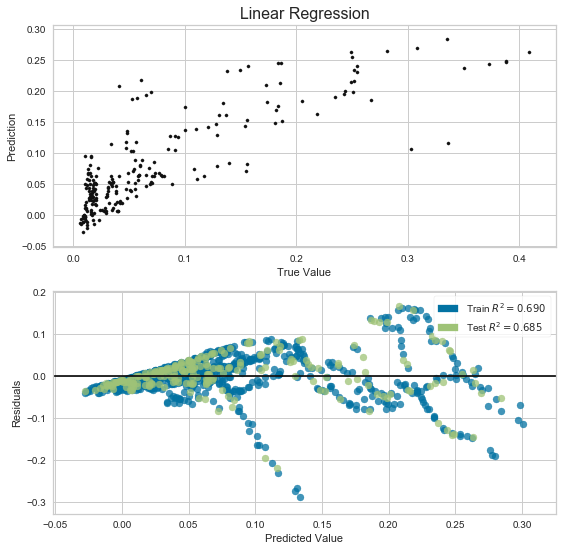

In [77]:
lm_ap = LinearRegression()
lm_ap.fit(X_train_ap,y_train_ap)
#y_train_pred=lm.predict(X_train_scale)
y_lm_val_ap= lm_ap.predict(X_val_ap)
print(lm_ap.coef_)

model_name='Linear Regression'
score(model_name,y_val_ap,y_lm_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(lm_ap,model_name,title,X_train_ap,y_train_ap,X_val_ap,y_val_ap,y_lm_val_ap)

#### Polynomial Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[ 0.          0.03236977 -0.00217984  0.14700232 -0.03772002 -0.00760347
 -0.01517649  0.01982129  0.07098573  0.0024176  -0.01597107 -0.00900655
 -0.03598439  0.0198344   0.00514305 -0.10495458  0.29560202 -0.30530986
 -0.03226868  0.07297917  0.07806671]
The calculated RMSE forPolynomial Regression is:0.03444017
The median absolute relative deviation is 0.2593 
The R squared  is 0.8446 


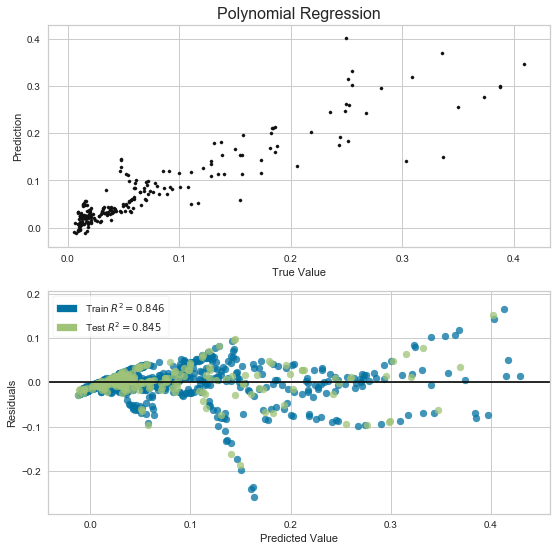

In [78]:
d=2
polynomial_features= PolynomialFeatures(degree=d)
x_poly_train_ap = polynomial_features.fit_transform(X_train_ap)
x_poly_val_ap = polynomial_features.fit_transform(X_val_ap)
poly_ap = LinearRegression()
poly_ap.fit(x_poly_train_ap,y_train_ap)
y_poly_val_ap = poly_ap.predict(x_poly_val_ap)
print(poly_ap.coef_)

model_name='Polynomial Regression'
score(model_name,y_val_ap,y_poly_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(poly_ap,model_name,title,x_poly_train_ap,y_train_ap,x_poly_val_ap,y_val_ap,y_poly_val_ap)

#### Kernel Ridge Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best estimator found by grid search:
{'alpha': 0.01, 'gamma': 10.0}
The calculated RMSE forKernel Ridge Regression is:0.00556652
The median absolute relative deviation is 0.0227 
The R squared  is 0.9959 


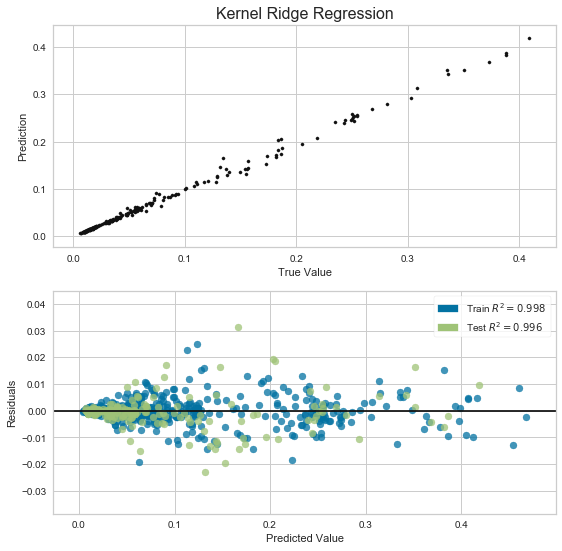

In [79]:
param_grid_kr ={"alpha": np.logspace(-5,-2,5),"gamma": np.logspace(-2,2,5)}
kr_ap = GridSearchCV(estimator=KernelRidge(kernel='rbf'),param_grid=param_grid_kr, cv=5)
#kr=KernelRidge(alpha=0.0001,gamma=10.0)
kr_ap.fit(X_train_ap, y_train_ap)
y_kr_val_ap = kr_ap.predict(X_val_ap)
print("Best estimator found by grid search:")
print(kr_ap.best_params_)

model_name='Kernel Ridge Regression'
score(model_name,y_val_ap,y_kr_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(kr_ap,model_name,title,X_train_ap,y_train_ap,X_val_ap,y_val_ap,y_kr_val_ap)

#### Support Vector Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'epsilon': [0.001, 0.01, 0.1],
                         'gamma': array([  1.,  10., 100.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Support vector ratio: 0.606
Best estimator found by grid search:
{'C': 10.0, 'epsilon': 0.001, 'gamma': 10.0}
The calculated RMSE forSupport Vector Regression is:0.00557768
The median absolute relative deviation is 0.0437 
The R squared  is 0.9959 


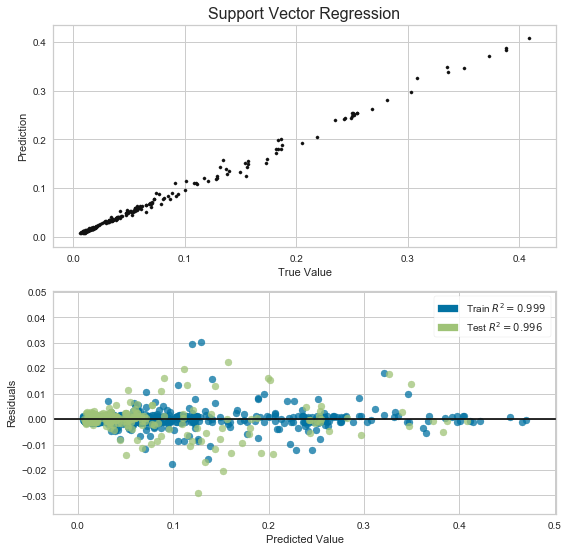

In [80]:
param_grid_svr={"C": np.logspace(0, 3, 4),"gamma": np.logspace(0, 2, 3), "epsilon": [0.001, 0.01, 0.1]}
svr_ap = GridSearchCV(SVR(kernel='rbf',cache_size=1000),param_grid_svr ,cv=5)

svr_ap.fit(X_train_ap, y_train_ap)

sv_ratio = svr_ap.best_estimator_.support_.shape[0] / X_train_ap.shape[0]
print("Support vector ratio: %.3f" % sv_ratio)

y_svr_val_ap = svr_ap.predict(X_val_ap)
print("Best estimator found by grid search:")
print(svr_ap.best_params_)

model_name='Support Vector Regression'
score(model_name,y_val_ap,y_svr_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(svr_ap,model_name,title,X_train_ap,y_train_ap,X_val_ap,y_val_ap,y_svr_val_ap)

#### Gradient Boosting Machine

In [81]:
# specify your configurations as a dict
# use rmsle to give more penlty for under-predicted value
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'max_depth': 6,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

lgb_train_ap = lgb.Dataset(X_train_ap, y_train_ap)
lgb_val_ap = lgb.Dataset(X_val_ap, y_val_ap, reference=lgb_train_ap)

print('Starting training...')

lgb_ap = lgb.train(params,
                lgb_train_ap,
                num_boost_round=10000,
                valid_sets=lgb_val_ap,
                early_stopping_rounds=20)

## Check pretrained model performance
y_lgb_val_ap= lgb_ap.predict(X_val_ap, num_iteration=lgb_ap.best_iteration)

Starting training...
[1]	valid_0's l2: 0.00701657	valid_0's l1: 0.0597154
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.00643814	valid_0's l1: 0.0570123
[3]	valid_0's l2: 0.00590328	valid_0's l1: 0.0545646
[4]	valid_0's l2: 0.00541105	valid_0's l1: 0.0521218
[5]	valid_0's l2: 0.00498669	valid_0's l1: 0.0499358
[6]	valid_0's l2: 0.00460853	valid_0's l1: 0.0479354
[7]	valid_0's l2: 0.00426684	valid_0's l1: 0.0459835
[8]	valid_0's l2: 0.00393932	valid_0's l1: 0.0441249
[9]	valid_0's l2: 0.00366109	valid_0's l1: 0.0423532
[10]	valid_0's l2: 0.00341008	valid_0's l1: 0.0407499
[11]	valid_0's l2: 0.00317155	valid_0's l1: 0.0392149
[12]	valid_0's l2: 0.00295167	valid_0's l1: 0.0377202
[13]	valid_0's l2: 0.00275639	valid_0's l1: 0.0363435
[14]	valid_0's l2: 0.00257939	valid_0's l1: 0.0350218
[15]	valid_0's l2: 0.00240002	valid_0's l1: 0.0335476
[16]	valid_0's l2: 0.0022498	valid_0's l1: 0.0322637
[17]	valid_0's l2: 0.00212348	valid_0's l1: 0.0311367
[18]	valid

The calculated RMSE forGradient Boosting Regression is:0.01085129
The median absolute relative deviation is 0.0815 
The R squared  is 0.9846 


YellowbrickTypeError: This estimator is not a regressor; try a classifier or clustering score visualizer instead!

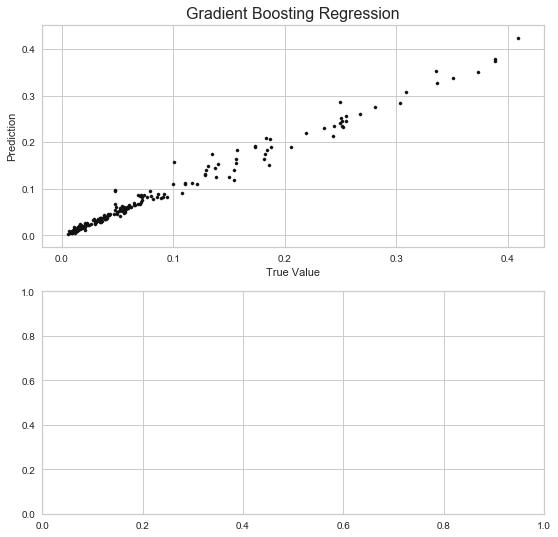

In [82]:
model_name='Gradient Boosting Regression'
score(model_name,y_val_ap,y_lgb_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(lgb_ap,model_name,title,X_train_ap,y_train_ap,X_val_ap,y_val_ap,y_lgb_val_ap)

#### Random Forest Regression

In [83]:
regressor = RandomForestRegressor(random_state=9,oob_score=True)
parameters = [{'max_features' : ['auto','sqrt','log2'],'n_estimators' : [10,20,40,60,80,100],'max_depth':[5,10,15,20,25,30]}]
rf_ap = GridSearchCV(estimator = regressor, param_grid = parameters)
rf_ap.fit(X_train_ap, y_train_ap)
best_parameters = rf_ap.best_params_
# Best paramete set
print('Best parameters found:\n', best_parameters)
y_rf_val_ap= rf_ap.predict(X_val_ap)

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=9,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

Best parameters found:
 {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 40}


The calculated RMSE forRandom Forest Regression is:0.00830639
The median absolute relative deviation is 0.0458 
The R squared  is 0.9910 


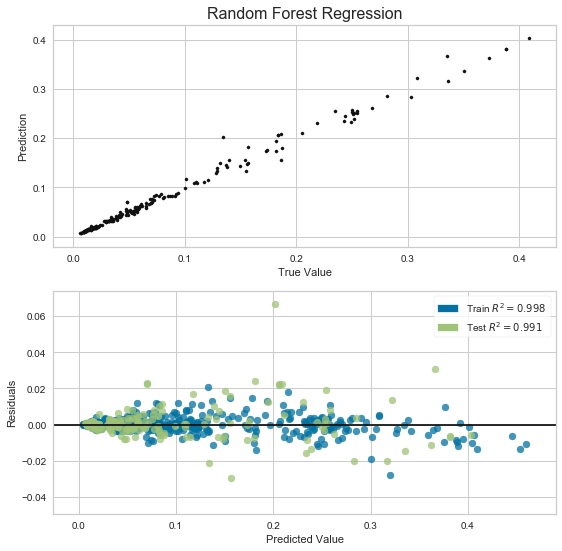

In [84]:
model_name='Random Forest Regression'
score(model_name,y_val_ap,y_rf_val_ap)
title=model_name+' Acceleration Pulse'
plot_result(rf_ap,model_name,title,X_train_ap,y_train_ap,X_val_ap,y_val_ap,y_rf_val_ap)

## Combine Both (Near Fault)

### Concatenate Data 

In [7]:
frames = [data_vp, data_ap]
data_nf = pd.concat(frames)
data_nf.head()

,Gamma,fp,A,PGA,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,2,0.729927,1.018,4.23000,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.107840
1,2,0.446429,0.306,0.77762,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.039144
2,2,0.476190,0.433,1.17380,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.048381
3,2,0.333333,0.860,1.63190,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.091070
4,2,0.196464,0.274,0.30644,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.033666


### Data Inspection

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

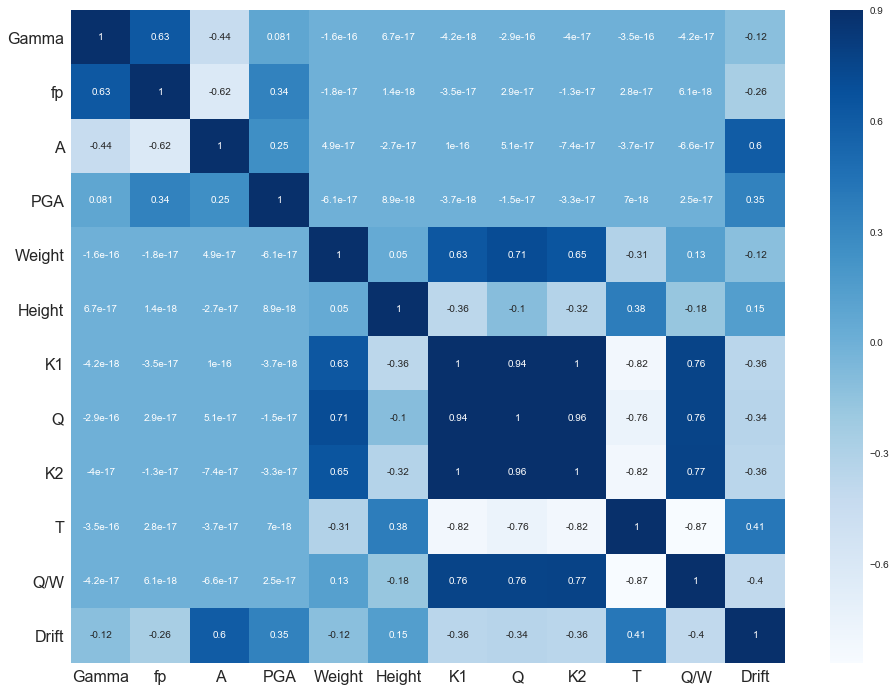

In [8]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
plt.xticks(rotation = 0,fontsize=16)
plt.yticks(fontsize=16)
#sns.heatmap(data_vp.corr(), vmax=0.9, cmap="YlGnBu" or "coolwarm", square=True, annot=True)
sns.heatmap(data_nf.corr(), vmax=0.9, cmap="Blues",  annot=True)

### Feature Selection

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Gamma$ (F-test=0.02, MI=0.20)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$fp$ (F-test=0.13, MI=0.98)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$A$ (F-test=1.00, MI=1.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Weight$ (F-test=0.02, MI=0.14)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Height$ (F-test=0.04, MI=0.16)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K1$ (F-test=0.26, MI=0.21)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K2$ (F-test=0.26, MI=0.22)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$T$ (F-test=0.37, MI=0.24)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Q/W$ (F-test=0.33, MI=0.23)')

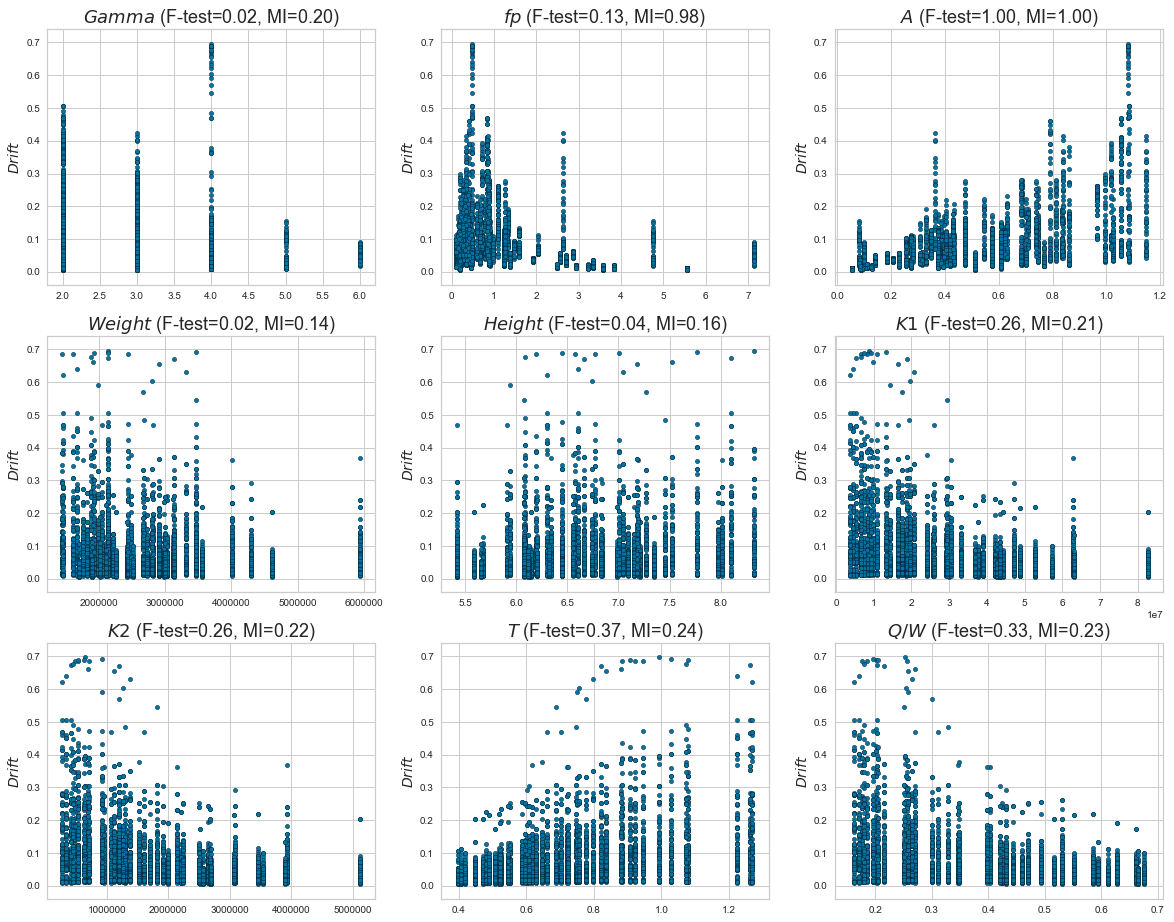

In [9]:
selected_feature_index = [0,1,2,4,5,6,8,9,10]
f_test, _ = f_regression(data_nf.iloc[:,selected_feature_index], data_nf.iloc[:,11])
f_test = f_test / np.max(f_test)
mi = mutual_info_regression(data_nf.iloc[:,selected_feature_index], data_nf.iloc[:,11])
mi = mi/np.max(mi)
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for i,axes in zip(range(10),ax.flatten()):
    axes.scatter(data_nf.iloc[:,selected_feature_index[i]], data_nf.iloc[:,11], edgecolor='black', s=20)
    #axes.set_xlabel("${}$".format(data_vp.columns[selected_feature_index[i]]), fontsize=14)
    axes.set_ylabel("$Drift$", fontsize=14)
    axes.set_title("${}$ (F-test={:.2f}, MI={:.2f})".format(data_nf.columns[selected_feature_index[i]],f_test[i], mi[i]),
              fontsize=18)

### Regression Analysis

In [10]:
# train
#X=np.array(Total_data.drop(['Weight','Height','K1','Q','K2','Drift'],axis=1))
X_nf=np.array(data_nf.drop(['PGA','Weight','K1','Q','K2','Drift'],axis=1))
y_nf=data_nf.values[:,11]

#Keep height for further drift ratio
X_train_nf, X_val_nf,y_train_nf,y_val_nf = train_test_split(X_nf,y_nf, test_size=0.2,shuffle=True,random_state=9)
Height_train_nf=X_train_nf[:,3]
Height_val_nf=X_val_nf[:,3]
X_train_nf=np.delete(X_train_nf, 3,axis=1)
X_val_nf=np.delete(X_val_nf, 3,axis=1)  

#### Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[ 0.01371952  0.00658556  0.2265431   0.11059208 -0.0963998 ]
The calculated RMSE forLinear Regression is:0.05849450
The median absolute relative deviation is 0.4963 
The R squared  is 0.6089 


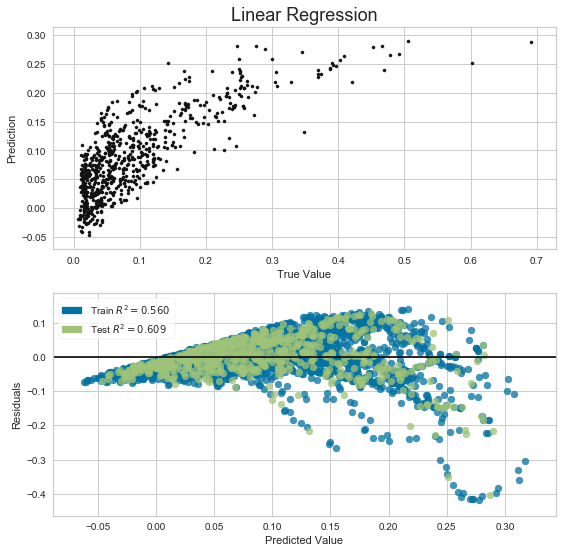

In [11]:
lm_nf = LinearRegression()
lm_nf.fit(X_train_nf,y_train_nf)
#y_train_pred=lm.predict(X_train_scale)
y_lm_val_nf= lm_nf.predict(X_val_nf)
print(lm_nf.coef_)

model_name='Linear Regression'
ARD_lm_nf=score(model_name,y_val_nf,y_lm_val_nf)
title=model_name+' Near Fault'
plot_result(lm_nf,model_name,title,X_train_nf,y_train_nf,X_val_nf,y_val_nf,y_lm_val_nf)

#### Polynomial Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[ 0.         -0.01762985 -0.01366127 -0.28342565  0.19777318  0.29694839
 -0.00641734  0.0145189   0.12079767  0.02062211 -0.04477793 -0.00365855
  0.06700763 -0.01327475 -0.02262968  0.1386115   0.22416971 -0.47609623
 -0.12107767 -0.10926319  0.10785435]
The calculated RMSE forPolynomial Regression is:0.04334711
The median absolute relative deviation is 0.3198 
The R squared  is 0.7852 


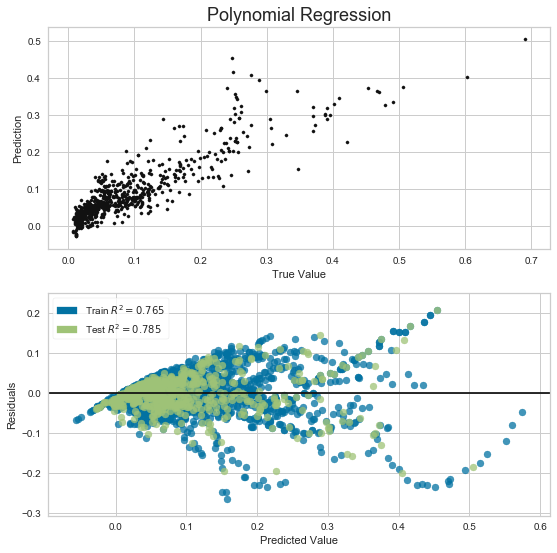

In [12]:
d=2
polynomial_features= PolynomialFeatures(degree=d)
x_poly_train_nf = polynomial_features.fit_transform(X_train_nf)
x_poly_val_nf = polynomial_features.fit_transform(X_val_nf)
poly_nf = LinearRegression()
poly_nf.fit(x_poly_train_nf,y_train_nf)
y_poly_val_nf = poly_nf.predict(x_poly_val_nf)
print(poly_nf.coef_)

model_name='Polynomial Regression'
ARD_poly_nf=score(model_name,y_val_nf,y_poly_val_nf)
title=model_name+' Near Fault'
plot_result(poly_nf,model_name,title,x_poly_train_nf,y_train_nf,x_poly_val_nf,y_val_nf,y_poly_val_nf)

#### Kernel Ridge Regression

In [13]:
param_grid_kr ={"alpha": np.logspace(-5,-2,5),"gamma": np.logspace(-2,2,5)}
kr_nf = GridSearchCV(estimator=KernelRidge(kernel='rbf'),param_grid=param_grid_kr, cv=5)
#kr=KernelRidge(alpha=0.0001,gamma=10.0)
kr_nf.fit(X_train_nf, y_train_nf)
y_kr_val_nf = kr_nf.predict(X_val_nf)
print("Best estimator found by grid search:")
print(kr_nf.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best estimator found by grid search:
{'alpha': 0.00031622776601683794, 'gamma': 10.0}


The calculated RMSE forKernel Ridge Regression is:0.01327279
The median absolute relative deviation is 0.0421 
The R squared  is 0.9799 


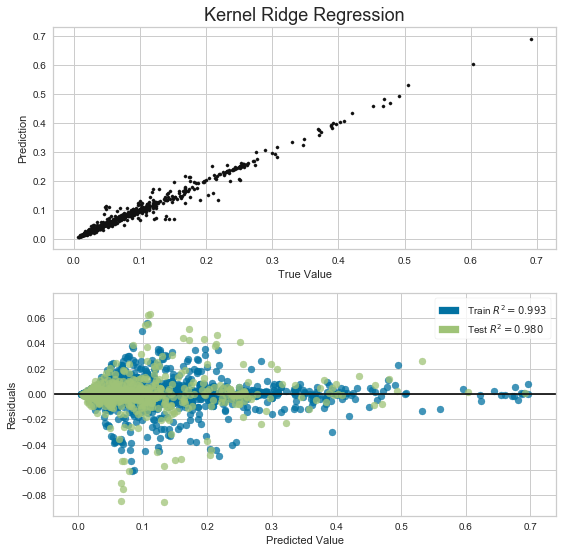

In [14]:
model_name='Kernel Ridge Regression'
ARD_kr_nf=score(model_name,y_val_nf,y_kr_val_nf)
title=model_name+' Near Fault'
plot_result(kr_nf,model_name,title,X_train_nf,y_train_nf,X_val_nf,y_val_nf,y_kr_val_nf)

#### Support Vector Regression

In [15]:
param_grid_svr={"C": np.logspace(0, 3, 4),"gamma": np.logspace(0, 2, 3), "epsilon": [0.0001,0.001, 0.01, 0.1]}
svr_nf = GridSearchCV(SVR(kernel='rbf',cache_size=1000),param_grid_svr ,cv=5)

svr_nf.fit(X_train_nf, y_train_nf)

sv_ratio = svr_nf.best_estimator_.support_.shape[0] / X_train_nf.shape[0]
print("Support vector ratio: %.3f" % sv_ratio)

y_svr_val_nf = svr_nf.predict(X_val_nf)
print("Best estimator found by grid search:")
print(svr_nf.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'epsilon': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': array([  1.,  10., 100.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Support vector ratio: 0.751
Best estimator found by grid search:
{'C': 10.0, 'epsilon': 0.001, 'gamma': 10.0}


The calculated RMSE forSupport Vector Regression is:0.01426223
The median absolute relative deviation is 0.0509 
The R squared  is 0.9768 


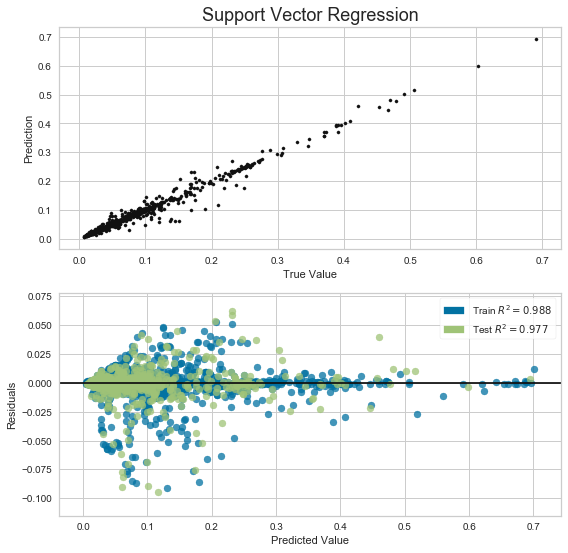

In [16]:
model_name='Support Vector Regression'
ARD_svr_nf=score(model_name,y_val_nf,y_svr_val_nf)
title=model_name+' Near Fault'
plot_result(svr_nf,model_name,title,X_train_nf,y_train_nf,X_val_nf,y_val_nf,y_svr_val_nf)

#### Gradient Boosting Machine

In [17]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr_nf = ensemble.GradientBoostingRegressor(random_state=9,**params)
gbr_nf.fit(X_train_nf, y_train_nf)
y_gbr_val_nf= gbr_nf.predict(X_val_nf)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The calculated RMSE forGradient Boosting Regression is:0.00797712
The median absolute relative deviation is 0.0429 
The R squared  is 0.9927 


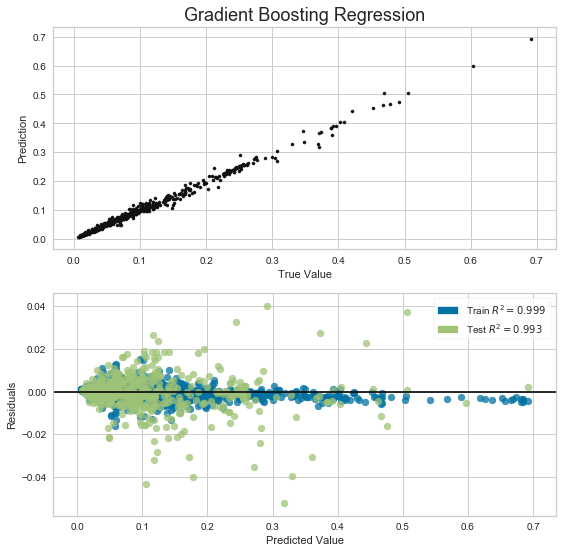

In [18]:
model_name='Gradient Boosting Regression'
ARD_gbr_nf=score(model_name,y_val_nf,y_gbr_val_nf)
title=model_name+' Near Fault'
plot_result(gbr_nf,model_name,title,X_train_nf,y_train_nf,X_val_nf,y_val_nf,y_gbr_val_nf)

#### Random Forest Regression

In [19]:
regressor = RandomForestRegressor(random_state=9,oob_score=True)
parameters = [{'max_features' : ['auto','sqrt','log2'],'n_estimators' : [10,20,40,60,80,100],'max_depth':[5,10,15,20,25,30]}]
rf_nf = GridSearchCV(estimator = regressor, param_grid = parameters)
rf_nf.fit(X_train_nf, y_train_nf)
best_parameters = rf_nf.best_params_
# Best paramete set
print('Best parameters found:\n', best_parameters)
y_rf_val_nf= rf_nf.predict(X_val_nf)

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=9,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

Best parameters found:
 {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}


The calculated RMSE forRandom Forest Regression is:0.00939632
The median absolute relative deviation is 0.0408 
The R squared  is 0.9899 


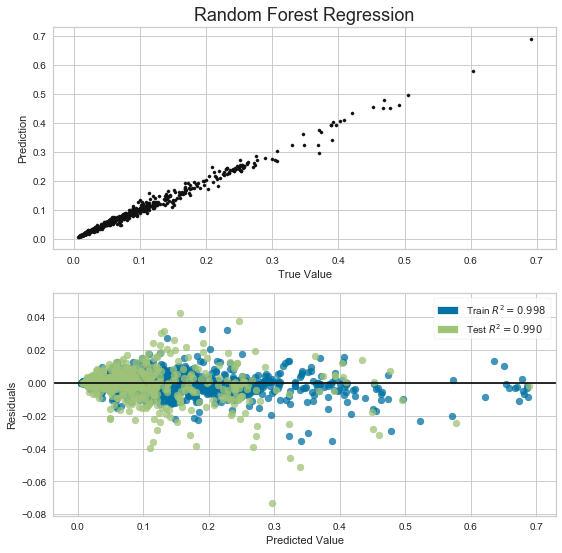

In [21]:
model_name='Random Forest Regression'
ARD_rf_nf=score(model_name,y_val_nf,y_rf_val_nf)
title=model_name+' Near Fault'
plot_result(rf_nf,model_name,title,X_train_nf,y_train_nf,X_val_nf,y_val_nf,y_rf_val_nf)

In [23]:
ARD_lm_nf=score(model_name,y_val_nf,y_lm_val_nf)
ARD_poly_nf=score(model_name,y_val_nf,y_poly_val_nf)
ARD_kr_nf=score(model_name,y_val_nf,y_kr_val_nf)
ARD_svr_nf=score(model_name,y_val_nf,y_svr_val_nf)
ARD_gbr_nf=score(model_name,y_val_nf,y_gbr_val_nf)
ARD_rf_nf=score(model_name,y_val_nf,y_rf_val_nf)

The calculated RMSE forRandom Forest Regression is:0.05849450
The median absolute relative deviation is 0.4963 
The R squared  is 0.6089 
The calculated RMSE forRandom Forest Regression is:0.04334711
The median absolute relative deviation is 0.3198 
The R squared  is 0.7852 
The calculated RMSE forRandom Forest Regression is:0.01327279
The median absolute relative deviation is 0.0421 
The R squared  is 0.9799 
The calculated RMSE forRandom Forest Regression is:0.01426223
The median absolute relative deviation is 0.0509 
The R squared  is 0.9768 
The calculated RMSE forRandom Forest Regression is:0.00797712
The median absolute relative deviation is 0.0429 
The R squared  is 0.9927 
The calculated RMSE forRandom Forest Regression is:0.00939632
The median absolute relative deviation is 0.0408 
The R squared  is 0.9899 


In [24]:
columns = ["Linear Regression", "Polynomial Regression", "Kernel Ridge Regression","Support Vector Regression","Gradient Boosting Regression","Random Forest Regression"]
data_nf = np.array([ARD_lm_nf, ARD_poly_nf,ARD_kr_nf,ARD_svr_nf,ARD_gbr_nf,ARD_rf_nf])
data_nf=data_nf.transpose()
ARD_near_fault = pd.DataFrame(data=data_nf, columns=columns)
ARD_near_fault.head()
ARD_near_fault.to_csv (r'ARD_Near_Fault.csv', index = False, header=True)

,Linear Regression,Polynomial Regression,Kernel Ridge Regression,Support Vector Regression,Gradient Boosting Regression,Random Forest Regression
0,0.980005,0.836367,0.077504,0.013206,0.037985,0.033914
1,3.583966,0.945053,0.302000,0.149152,0.100442,0.349097
2,7.331465,1.715392,0.013680,0.118062,0.013837,0.033761
3,0.522094,0.287508,0.014670,0.028171,0.002221,0.025932
4,0.783123,0.248899,0.144905,0.150873,0.038316,0.051426


### Closed Function

#### No1

In [98]:
X_new_train=np.copy(X_train_nf)
#X_new_train[:,1]=X_new_train[:,1]**-2
#X_new_train[:,3]=X_new_train[:,3]**-1

X_new_val=np.copy(X_val_nf)
#X_new_val[:,1]=X_new_val[:,1]**-2
#X_new_val[:,3]=X_new_val[:,3]**-1

In [106]:
### y=f(gamma**a,(fp)**b,(A)**c,(Q/W)**d,(T)**e)
A=np.linspace(-2, 2, num=5)
#B=np.linspace(-3, -1, num=5)
B=[-2]
C=np.linspace(-3, 3, num=13)
#D=np.linspace(-3, 0, num=7)
D=[-1]
E=np.linspace(-3, 3, num=13)
error={}

for a in A:
    for b in B:
        for c in C:
            for d in D:
                for e in E:  
                    X_train = np.copy(X_new_train)
                    X_train[:,0] = X_new_train[:,2]**a
                    X_train[:,1] = X_new_train[:,4]**b
                    X_train[:,2] = X_new_train[:,2]**c
                    X_train[:,3] = X_new_train[:,4]**d
                    X_train[:,4] = X_new_train[:,4]**e
        
                    X_val = np.copy(X_new_val)
                    X_val[:,0] = X_new_val[:,0]**a
                    X_val[:,1] = X_new_val[:,1]**b
                    X_val[:,2] = X_new_val[:,2]**c
                    X_val[:,3] = X_new_val[:,3]**d
                    X_val[:,4] = X_new_val[:,4]**e
        
                    lm = LinearRegression()
                    lm.fit(X_train,y_train_nf)
                    #y_train_pred=lm.predict(X_train_scale)
                    y_val= lm.predict(X_val)
                    error[(a,b,c,d,e)]=sqrt(mean_squared_error(y_val, y_val_nf))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
best_param= min(error, key=lambda k: error[k]) 
print("Best coefficients found by grid search:")
print(best_param)
a,b,c,d,e=best_param

Best coefficients found by grid search:
(-1.0, -2, 2.0, -1, -1.0)


In [108]:
X_train = np.copy(X_new_train)
X_train[:,0] = X_new_train[:,2]**a
X_train[:,1] = X_new_train[:,4]**b
X_train[:,2] = X_new_train[:,2]**c
X_train[:,3] = X_new_train[:,4]**d
X_train[:,4] = X_new_train[:,4]**e

X_val = np.copy(X_new_val)
X_val[:,0] = X_new_val[:,0]**a
X_val[:,1] = X_new_val[:,1]**b
X_val[:,2] = X_new_val[:,2]**c
X_val[:,3] = X_new_val[:,3]**d
X_val[:,4] = X_new_val[:,4]**e

lm = LinearRegression()
lm.fit(X_train,y_train_nf)
#y_train_pred=lm.predict(X_train_scale)
y_val= lm.predict(X_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
print("The calculated RMSE is:%0.8f" % (sqrt(mean_squared_error(y_val_nf, y_val))))
MARD=np.median(np.absolute(y_val-y_val_nf)/(y_val_nf))
print("The median absolute relative deviation is %.4f "% (MARD))
r2 = r2_score(y_val_nf, y_val)
print("The R squared  is %.4f "% (r2))

The calculated RMSE is:0.07802023
The median absolute relative deviation is 0.4254 
The R squared  is 0.4082 


#### No2

X_train_nf, X_val_nf,y_train_nf,y_val_nf 

In [112]:
X_new_train=np.copy(X_train_nf)
y_new_train=np.copy(y_train_nf)

X_new_val=np.copy(X_val_nf)
y_new_val=np.copy(y_val_nf)

In [114]:
X_train=np.log(X_new_train)
y_train=np.log(y_new_train)

X_val=np.log(X_new_val)
#y_val=math.log(y_new_val)

In [116]:
lm = LinearRegression()
lm.fit(X_train,y_train)
#y_train_pred=lm.predict(X_train_scale)
y_val_log= lm.predict(X_val)
y_val=np.exp(y_val_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
print("The calculated RMSE is:%0.8f" % (sqrt(mean_squared_error(y_val_nf, y_val))))
MARD=np.median(np.absolute(y_val-y_val_nf)/(y_val_nf))
print("The median absolute relative deviation is %.4f "% (MARD))
r2 = r2_score(y_val_nf, y_val)
print("The R squared  is %.4f "% (r2))

The calculated RMSE is:0.05725701
The median absolute relative deviation is 0.3071 
The R squared  is 0.6813 


#### No3